In [1]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OneHotEncoder


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"


config = Config()

sys.path.append(str(config.REPO_ROOT))

In [2]:
from python.src.preprocess import (
    preprocess_bike_data,
)

df_bike = pd.read_csv(config.data_dir / "bike+sharing+dataset" / "day.csv")
df_bike_processed = preprocess_bike_data(df_bike=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

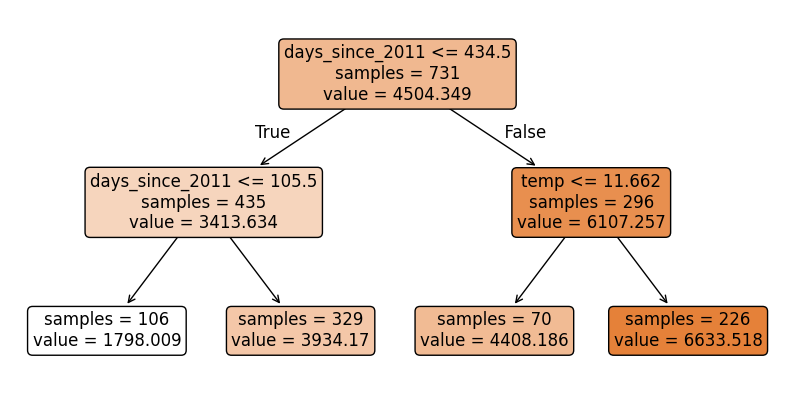

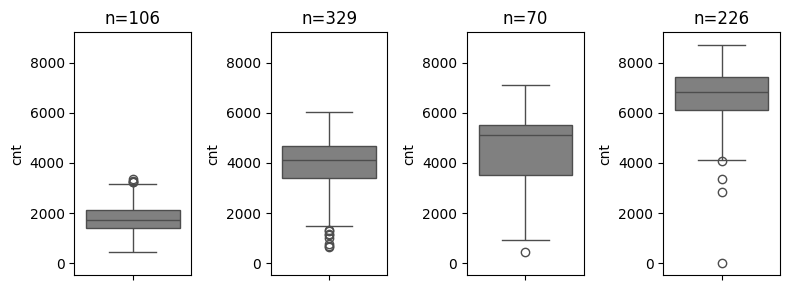

In [50]:
# 必要な特徴量を選択
features_of_interest = [
    "days_since_2011",
    "temp",
    "season",
    "windspeed",
    "hum",
]  # Rのコードに合わせる
# X = df_bike_processed[features_of_interest]
# y = df_bike_processed["cnt"]
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# カテゴリ変数と数値変数を分離
categorical_features = ["season"]
numerical_features = ["days_since_2011", "temp", "windspeed", "hum"]
# OneHotEncoderを適用
encoded_features = enc.fit_transform(df_bike_processed[categorical_features])
encoded_df = pd.DataFrame(
    encoded_features, columns=enc.get_feature_names_out(categorical_features)
)

# 数値変数と結合
X = pd.concat([df_bike_processed[numerical_features], encoded_df], axis=1)
y = df_bike_processed["cnt"]
# 決定木の構築
ct = DecisionTreeRegressor(max_depth=2, random_state=42)
ct.fit(X, y)


# 決定木の可視化
plt.figure(figsize=(10, 5))
plot_tree(
    ct,
    feature_names=features_of_interest,
    filled=True,
    rounded=True,
    fontsize=12,
    impurity=False,
)
plt.show()


# boxplot を表示 (修正)
def get_node_data(tree, X, node_id):
    node_indicator = tree.decision_path(X)
    return X[node_indicator[:, node_id].toarray().flatten() == 1]


terminal_nodes = ct.apply(X)

fig, axes = plt.subplots(1, 4, figsize=(8, 3))
y_min = y.min()
y_max = y.max()

for i, node_id in enumerate(np.unique(terminal_nodes)):
    node_data = get_node_data(ct, X, node_id)
    node_y = y.loc[node_data.index]

    sns.boxplot(y=node_y, ax=axes[i], color="gray")
    axes[i].set_title(f"n={len(node_y)}")
    axes[i].set_ylim(y_min - 500, y_max + 500)


plt.tight_layout()
plt.show()

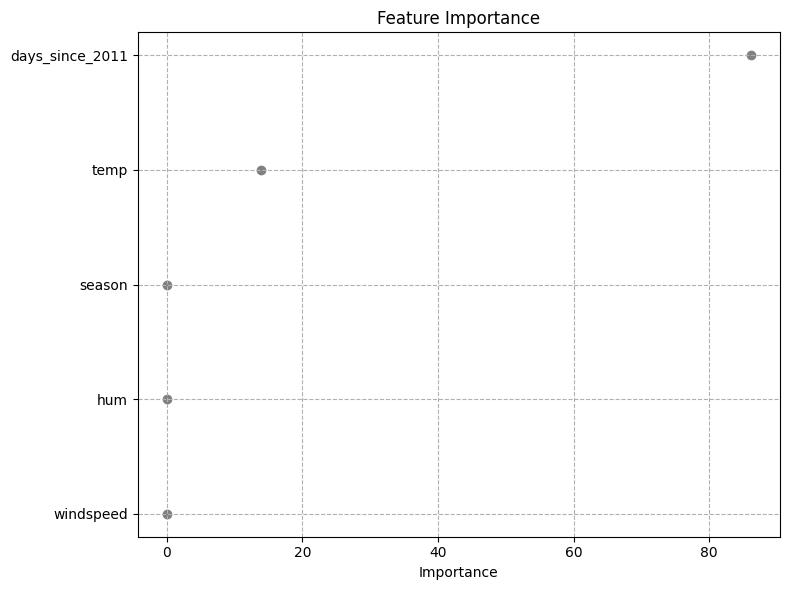

In [58]:
# 特徴量の重要度を計算
imp = 100 * ct.feature_importances_ / np.sum(ct.feature_importances_)
imp_df = pd.DataFrame({"feature": X.columns, "importance": imp})
season_importance = imp_df[imp_df["feature"].str.startswith("season_")][
    "importance"
].sum()

# 'season_' で始まる行を削除
imp_df = imp_df[~imp_df["feature"].str.startswith("season_")]

# 'season' 行を追加
imp_df = pd.concat(
    [imp_df, pd.DataFrame({"feature": ["season"], "importance": [season_importance]})],
    ignore_index=True,
)

# 重要度の低い順に特徴量をソート
imp_df = imp_df.sort_values("importance")

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(imp_df["importance"], imp_df["feature"], color="gray")  # xとyを入れ替え
ax.set_ylabel("")  # xlabelとylabelを入れ替え
ax.set_xlabel("Importance")  # 空白にする
ax.set_title("Feature Importance")
ax.grid(linestyle="--")
plt.tight_layout()
plt.show()